# imports:

In [3]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics.SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist, euclidean


from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions2 import *
from SampleLists.SampleFileFunctions import *
from PhenotypicData.PhenotypeGenerationFunctions import *
from CardioProject.CardioFunctions import *
from PredictionPipeline.PredictionFunctions import *
from TCR_feature_generation.SubsamplingFunctions import *

import os
from Utils import cacheOnDisk
from SegalQueue.qp import qp,fakeqp
from addloglevels import sethandlers

#ML imports:
from xgboost import XGBClassifier
import lightgbm as lgb
from collections import OrderedDict
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
import shap
from sklearn import metrics, preprocessing
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,mutual_info_classif,f_classif
from sklearn.naive_bayes import GaussianNB

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126


done1
stop
stop
done1
stop
done
done
done
done
stop
stop
end of function!!!
end of function!!!


In [4]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate

'18022019'

# notebook content:
1. generate annotation features
2. generate new X table containing traditional TCR features, annotation features, 10 PCs over all shared by >10% (w/o sequences themselves)
3. 

# generate new features - ran again on 191018 using the new relative annotation features:

the function gen_annotation_features_for_dataset was copied to TCR_feature_generation.py
    

In [ ]:
#run for PNP530
datasetFolder='%s/TCR_real_data' %MyPath
datasetName='PNP530'
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
sampleList=PNP530
sampleListName='PNP530'

annotationFeatureDF,annotationFeatureDF_processed=gen_annotation_features_for_dataset(datasetFolder,datasetName,
                                                                    sampleList,sampleListName)

In [ ]:
#run for Cardio126
datasetFolder='%s/TCR_real_data/CardioSamples' %MyPath
datasetName='Cardio126'
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
sampleList=Cardio126
sampleListName='Cardio126'

annotationFeatureDF,annotationFeatureDF_processed=gen_annotation_features_for_dataset(datasetFolder,datasetName,
                                                                    sampleList,sampleListName)

# generate new X:

1. get PCs
2. merge classic features, PCs and annotation features
3. save
4. correct features for association with age, gender and HbA1c
5. save

## generate all components in the combined folder:

### TCR feature df:

already exist

### annot_features:

In [ ]:
print 'getting annot_features'
f1='%s/TCR_real_data/annotationFeatures/PNP530_PNP530_annotationFeatures.xlsx' %MyPath
PNP_annotFeat=pd.read_excel(f1)

f2='%s/TCR_real_data/CardioSamples/annotationFeatures/Cardio126_Cardio126_annotationFeatures.xlsx'  %MyPath
Cardio_annotFeat=pd.read_excel(f2)

#**************************
annotFeat=pd.concat([PNP_annotFeat,Cardio_annotFeat])
print 'removing non-normalized seq_count and cum_freq columns'
dropList=[]

for col in annotFeat.columns:
    if ('seq_count' in col) and ('rel' not in col):
        dropList.append(col)
    elif ('cum_freq' in col) and ('rel' not in col):
        dropList.append(col)
print ('drop list length is:', len(dropList))
annotFeat=annotFeat.drop(dropList,axis=1)
#**************************

print ('combined annotation feature df shape:',annotFeat.shape )

annotFeat_processed,analysisDF,annotFeatnameAddition=process_featureDF(annotFeat,corrThreshold=0.99,
                                        removeCorr=True,exploreDF=True,deleteConsts=True,fillnans=True)


In [ ]:
annotationFolder='%s/TCR_real_data/PNP530Cardio126Combined/annotationFeatures' %MyPath
if not isdir(annotationFolder):
    makedirs(annotationFolder)
    
datasetName='PNP530Cardio126'
sampleListName='PNP530Cardio126'
    
f4='%s/%s_%s_annotationFeatures_withRels.xlsx' %(annotationFolder,datasetName,sampleListName)
annotFeat.to_excel(f4)


f5='%s/%s_%s_annotationFeatures_withRels_ANALYSIS.xlsx' %(annotationFolder,datasetName,sampleListName)
analysisDF.to_excel(f5)

f6='%s/%s_%s_annotationFeatures_withRels' %(annotationFolder,datasetName,sampleListName) + annotFeatnameAddition +'.xlsx'
annotFeat_processed.to_excel(f6)

### TCRdf 10%

ALREADY EXIST

### get PCAdf for PNP530+Cardio126

In [ ]:
datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined' %MyPath
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
sampleList=PNP530+Cardio126

#targetDF
targetDF=pd.DataFrame(index=['BD'+str(x) for x in range(1,1100)])
targetDF['isCardio']=np.where(targetDF.index.str.replace('BD','').astype(int)>949,1,0)
targetDF=targetDF.loc[sampleList,:]


#TCRdf:
print 'getting TCRdf...'
percShared=10

sharingFolder='%s/sharingAnalysis' %datasetFolder
TCRdfName='sharingMatrix_PNP530Cardio126_minNshared5_RA_onlyProductiveTrue__percShared%s_OLtrimmed_binary' %percShared
TCRdfFile='%s/%s' %(sharingFolder,TCRdfName )
print TCRdfFile
TCRdf=pd.read_pickle(TCRdfFile)
print 'TCRdf shape is %s_%s' %(TCRdf.shape[0],TCRdf.shape[1])
print TCRdf.iloc[:4,:4]

#PCA:
y=targetDF
YName='isCardio'
n_comp=10
isSparse=True
fig,ax=plt.subplots()
TCRdf=editSampleNames(TCRdf)
TCRdf = TCRdf.loc[[str(x) for x in TCRdf.index.tolist() if x in y.index], :]
PCAdf,ax,p_ttest_PC1,p_ttest_PC2 = PCAfunc(TCRdf,n_comp,isSparse,ax,groupingByDF=y, groupbyName=YName)
for c in ['BDindex', YName]:
    try:
        PCAdf = PCAdf.drop(c, axis=1)
    except:
        print 'PCAdf doesnt include %s column' % c
print 'PCAdf shape is %s_%s' % (PCAdf.shape[0], PCAdf.shape[1])


f3='%s/sharingAnalysis/PCAdf_%spercShared' %(datasetFolder,percShared)
PCAdf.to_pickle(f3)

## merge X and name it

In [ ]:
the function gen_TCRfeatureX was copied to TCR_feature_generation_functions.py

In [ ]:
withRels=True

datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined' %MyPath
datasetName='PNP530Cardio126'

incSingleSeqs=True
TCRfeatureX=gen_TCRfeatureX(datasetFolder,datasetName,incSingleSeqs,withRels=withRels)

incSingleSeqs=False
TCRfeatureX=gen_TCRfeatureX(datasetFolder,datasetName,incSingleSeqs,withRels=withRels)

print TCRfeatureX.columns.tolist()
print len(TCRfeatureX.columns)

# correct X for confounders:

1. correct all x components for age
2. run again correlation calculation and see if there are still correlations with gender
3. if so, correct for gender and test again for age
4. if ok, check again correlations and see if there are still correlations with HbA1C
5. if so, correct for HbA1C and check again age and gender.
6. if everything is ok, consider correcting for one more phenotype-BMi probbaly

## functions:

In [ ]:
#check which feature needs correction:
def check_features_to_correct(X,phenotypeDF,phen,featureDFname=None,sampleSubset=None,calcAssociations=True,FDR=0.25):
    
    #definitions:
    featureDF=X.copy()
    phenotypeDF = pd.DataFrame(phenotypeDF[phen])
    if sampleSubset is not None:
        featureDF=featureDF.loc[sampleSubset,:]
        phenotypeDF = phenotypeDF.loc[sampleSubset,:]
    if featureDFname is None:
        featureDFname='all'
    phenDFname=phen
    testType='pearson'
    
    print ('phenotype series type:',phenotypeDF[phen].dtype)
    
    if phenotypeDF[phen].nunique()==2:
        f1='%s/TCR_real_data/TCR_phenotype_relations/%sTCRfeatures_%s_ttest.xlsx' %(MyPath,featureDFname,phenDFname)
    elif phenotypeDF[phen].nunique()>2:
        f1='%s/TCR_real_data/TCR_phenotype_relations/%sTCRfeatures_%s_%sTest.xlsx' %(MyPath,featureDFname,phenDFname,testType)       
      
    if calcAssociations:
        print 'checking associations between %s and all TCR features:' %phen
        if phenotypeDF[phen].nunique()==2:
            print 'number of phenotype unique values is %s and therefore ttest is used' %phenotypeDF[phen].nunique()
            feature_phen_assoc=calc_catPhens_TCRfeatures_associations_ttest(featureDF,featureDFname,phenotypeDF,phenDFname,FDR)
        elif phenotypeDF[phen].nunique()>2:
            print 'number of phenotype unique values is %s and therefore correlation test is used' %phenotypeDF[phen].nunique()
            feature_phen_assoc=calc_numPhens_TCRfeatures_associations_correlation(featureDF,featureDFname,phenotypeDF,phenDFname,testType,FDR)
        feature_phen_assoc.to_excel(f1)
    else:
        feature_phen_assoc=pd.read_excel(f1)
        
    #CHECK WHICH FEATURES TO CORRECT:
    sigDF=feature_phen_assoc[feature_phen_assoc['sig. by FDR=%s' %FDR]==1]
    featToCorrect=sigDF['Feature'].unique().tolist()
    print ('number of features to correct is:',len(featToCorrect))
    print ('the most significantly associated features are:',sigDF['Feature'].unique().tolist()[:5])
    
    return featToCorrect

# regress feature using phenotype data and generate the resulting residuals:
# the function should take feature data and phenotype data for PNP530+Cardio126!!!!

def calc_residuals(feature_data,phen_data,featureName,sampleSubset):
    lm=LinearRegression()
    lm.fit(phen_data.loc[sampleSubset,:],feature_data.loc[sampleSubset,:])
    y_pred=pd.DataFrame(index=phen_data.index.tolist(),data=lm.predict(phen_data))
    
    merged=pd.merge(feature_data,y_pred,how='inner',left_index=True, right_index=True)
    merged['res']=merged[featureName]-merged[0]
    print ('sum of residuals for the fitted data only:', merged.loc[sampleSubset,'res'].sum())
    
#     print merged.head(10)
    print merged[featureName].median()
    return merged['res']
        
    

## correct X for age,gender eGFR by CKD-EPI, and check resulting correlations with age,gender,HbA1C and Glucose:

In [ ]:
withRels=False


#PNP530 and Cardio126 samples:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126


#load original X:
if withRels:
    f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels.dat' %MyPath
else:
    f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10_.dat' %MyPath
allFeatures=pd.read_pickle(f1).loc[PNP530Cardio126,:]
print ('original X shape is:', allFeatures.shape)
print allFeatures.iloc[:4,:4]

#load phenotypeDF:
f2='%s/TCR_real_data/PNP530Cardio126Combined/Phenotypes/PNP530Cardio126_AllInfo_withDummies.xlsx' %MyPath
phenotypeDF=pd.read_excel(f2).set_index('BD').loc[PNP530Cardio126,:]
print ('phenotype DF shape is:', phenotypeDF.shape)
print phenotypeDF.iloc[:4,:4]

#check which features need correction for age:
print 'checking which features need correction for age:'
X=allFeatures
phen='Age'
sampleSubset=PNP530

featToCorrect=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset)


#correct all featues for age and generate new X:
X_ageCorr=pd.DataFrame(index=X.index, columns=X.columns,data=np.nan)
X_ageCorr=X_ageCorr.loc[PNP530Cardio126,:] #ensure sample order
for n,feature in enumerate(X_ageCorr.columns):
    print n,feature
    if feature in featToCorrect:
        
        phen_data=pd.DataFrame(phenotypeDF['Age'].fillna(phenotypeDF['Age'].median())).loc[PNP530Cardio126,:]
        feature_data=pd.DataFrame(X[feature].fillna(0)) 
        featureName=feature
        
        res=calc_residuals(feature_data,phen_data,featureName,PNP530) #use only PNP530 samples to study
        X_ageCorr=pd.merge(X_ageCorr,pd.DataFrame(res),how='inner',left_index=True, right_index=True)
        X_ageCorr=X_ageCorr.rename(columns={'res':feature+'_AgeCorrRes'})
        X_ageCorr=X_ageCorr.drop(feature,axis=1)
    else:
        X_ageCorr[feature]=X[feature]
print ('X_ageCorr shape after correcting all features is',X_ageCorr.shape)

f3=f1.replace('.dat','_%sCorrRes.dat' %phen)
X_ageCorr.to_pickle(f3)

#check again correlation with age and make sure there are nothing:
print 'checking which features are still corrected for age:'
X=X_ageCorr
phen='Age'
sampleSubset=PNP530
featureDFname='AgeCorrRes'
stillcorrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#check association with gender:
print 'checking which features are now associated with gender:'
X=X_ageCorr
phen='Gender_Male'
sampleSubset=PNP530
featureDFname='AgeCorrRes'
GenderCorrrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#correct all featues for gender and generate new X:
X_AgeGenderCorr=pd.DataFrame(index=X.index, columns=X.columns,data=np.nan)
X_AgeGenderCorr=X_AgeGenderCorr.loc[PNP530Cardio126,:] #ensure sample order
for n,feature in enumerate(X_AgeGenderCorr.columns):
    print n,feature
    if feature in GenderCorrrelated:
        
        phen_data=pd.DataFrame(phenotypeDF['Gender_Male'].fillna(phenotypeDF['Gender_Male'].median())).loc[PNP530Cardio126,:]
        feature_data=pd.DataFrame(X[feature].fillna(0)) 
        featureName=feature
        
        res=calc_residuals(feature_data,phen_data,featureName,PNP530) #use only PNP530 samples to study
        X_AgeGenderCorr=pd.merge(X_AgeGenderCorr,pd.DataFrame(res),how='inner',left_index=True, right_index=True)
        X_AgeGenderCorr=X_AgeGenderCorr.rename(columns={'res':feature+'_GenderCorrRes'})
        X_AgeGenderCorr=X_AgeGenderCorr.drop(feature,axis=1)
    else:
        X_AgeGenderCorr[feature]=X[feature]
print ('X_AgeGenderCorr shape after correcting all features is',X_AgeGenderCorr.shape)

f4=f1.replace('.dat','_AgeGenderCorr.dat')
X_AgeGenderCorr.to_pickle(f4)

#check again correlation with age and make sure there are nothing:
print 'checking which features are correlated with age after gender correction:'
X=X_AgeGenderCorr
phen='Age'
sampleSubset=PNP530
featureDFname='AgeGenderCorrRes'
stillcorrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#check association with gender:
print 'checking which features are associated with gender after correction for gender:'
X=X_AgeGenderCorr
phen='Gender_Male'
sampleSubset=PNP530
featureDFname='AgeGenderCorrRes'
GenderCorrrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#check association with HbA1C:
print 'checking which features are associated with HbA1C after correction for gender:'
X=X_AgeGenderCorr
phen='HbA1C'
sampleSubset=PNP530
featureDFname='AgeGenderCorrRes'
GenderCorrrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#check association with Glucose:
print 'checking which features are associated with Glucose after correction for gender:'
X=X_AgeGenderCorr
phen='Glucose'
sampleSubset=PNP530
featureDFname='AgeGenderCorrRes'
GenderCorrrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#check association with WakeupGlucose:
print 'checking which features are associated with WakeupGlucose after correction for gender:'
X=X_AgeGenderCorr
phen='WakeupGlucose'
sampleSubset=PNP530
featureDFname='AgeGenderCorrRes'
GlucoseCorrrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#check association with eGFR by CKD-EPI:
print 'checking which features are associated with eGFR by CKD-EPI after correction for gender:'
X=X_AgeGenderCorr
phen='eGFR by CKD-EPI'
sampleSubset=PNP530
featureDFname='AgeGenderCorrRes'
GFRCorrrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#correct all featues for eGFR by CKD-EPI and generate new X:
X_AgeGenderGFRCorr=pd.DataFrame(index=X.index, columns=X.columns,data=np.nan)
X_AgeGenderGFRCorr=X_AgeGenderGFRCorr.loc[PNP530Cardio126,:] #ensure sample order
for n,feature in enumerate(X_AgeGenderGFRCorr.columns):
    print n,feature
    if feature in GFRCorrrelated:
        
        phen_data=pd.DataFrame(phenotypeDF['eGFR by CKD-EPI'].fillna(phenotypeDF['eGFR by CKD-EPI'].median())).loc[PNP530Cardio126,:]
        feature_data=pd.DataFrame(X[feature].fillna(0)) 
        featureName=feature
        
        res=calc_residuals(feature_data,phen_data,featureName,PNP530) #use only PNP530 samples to study
        X_AgeGenderGFRCorr=pd.merge(X_AgeGenderGFRCorr,pd.DataFrame(res),how='inner',left_index=True, right_index=True)
        X_AgeGenderGFRCorr=X_AgeGenderGFRCorr.rename(columns={'res':feature+'_GFRCorrRes'})
        X_AgeGenderGFRCorr=X_AgeGenderGFRCorr.drop(feature,axis=1)
    else:
        X_AgeGenderGFRCorr[feature]=X[feature]
print ('X_AgeGenderGFRCorr shape after correcting all features is',X_AgeGenderCorr.shape)

f5=f1.replace('.dat','_AgeGenderGFRCorr.dat')
X_AgeGenderGFRCorr.to_pickle(f5)

#check again correlation with age and make sure there are nothing:
print 'checking which features are correlated with age after GFR correction:'
X=X_AgeGenderGFRCorr
phen='Age'
sampleSubset=PNP530
featureDFname='AgeGenderGFRCorrRes'
stillcorrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#check association with gender:
print 'checking which features are associated with gender after correction for gender:'
X=X_AgeGenderGFRCorr
phen='Gender_Male'
sampleSubset=PNP530
featureDFname='AgeGenderGFRCorrRes'
GenderCorrrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#check association with HbA1C:
print 'checking which features are associated with HbA1C after correction for gender:'
X=X_AgeGenderGFRCorr
phen='HbA1C'
sampleSubset=PNP530
featureDFname='AgeGenderGFRCorrRes'
GenderCorrrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#check association with Glucose:
print 'checking which features are associated with Glucose after correction for gender:'
X=X_AgeGenderGFRCorr
phen='Glucose'
sampleSubset=PNP530
featureDFname='AgeGenderGFRCorrRes'
GenderCorrrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#check association with GFR:
print 'checking which features are associated with Glucose after correction for gender:'
X=X_AgeGenderGFRCorr
phen='eGFR by CKD-EPI'
sampleSubset=PNP530
featureDFname='AgeGenderGFRCorrRes'
GenderCorrrelated=check_features_to_correct(X,phenotypeDF,phen,sampleSubset=sampleSubset,featureDFname=featureDFname)

#use old X and new X for predictions:
print 'done'



In [ ]:
325./671

## check associations of corrected features with all other phenotypes 
to decide whether additional correction is needed and to show relationships between features and phenotypes:

In [ ]:
#PNP530 and Cardio126 samples:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126


#load corrected X:
f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels_AgeGenderGFRCorr.dat' %MyPath
X_corrected=pd.read_pickle(f1).loc[PNP530,:]
print ('X_corrected shape is:', X_corrected.shape)
print allFeatures.iloc[:4,:4]

#load phenotypeDF:
f2='%s/TCR_real_data/PNP530Cardio126Combined/Phenotypes/PNP530Cardio126_AllInfo_withDummies.xlsx' %MyPath
phenotypeDF=pd.read_excel(f2).set_index('BD').loc[PNP530,:]
print ('phenotype DF shape is:', phenotypeDF.shape)
print phenotypeDF.iloc[:4,:4]

#phenotypes with information for more than 520 samples:
phenList_num=['AST', 'Age', 'BMI','Glucose', 'HDL', 'HbA1C','Hemoglobin', 'Total Cholesterol', 'WBC', 'eGFR by CKD-EPI']
phenList_cat=['Gender_Male','Smoking Status_Yes','Smoking Status_Past']

#check pearson correlation with numerical phenotypes:
featureDF=X_corrected.copy()
featureDFname='PNP530AgeGenderCorrResTCRfeatures'
phenDF = phenotypeDF[phenList_num].copy()
phenDFname='num_phens'
testType='pearson'
FDR=0.1


feature_phen_pearson=calc_numPhens_TCRfeatures_associations_correlation(featureDF,featureDFname,phenDF,phenDFname,testType,FDR=0.1)

f3='%s/TCR_real_data/TCR_phenotype_relations/%sTCRfeatures_%s_%sTest.xlsx' %(MyPath,featureDFname,phenDFname,testType)
feature_phen_pearson.to_excel(f3)

#check ttest with binary phenotypes:

phenDF = phenotypeDF[phenList_cat].copy()
phenDFname='cat_phens'

feature_phen_ttest=calc_catPhens_TCRfeatures_associations_ttest(featureDF,featureDFname,phenDF,phenDFname,FDR)

f4='%s/TCR_real_data/TCR_phenotype_relations/%sTCRfeatures_%s_ttest.xlsx' %(MyPath,featureDFname,phenDFname)
feature_phen_ttest.to_excel(f4)

In [ ]:
phenotypeList=[]
for phen in phenotypeDF.columns:
    count=phenotypeDF[phen].count()
#     print phen,count
    if count>520:
        phenotypeList.append(phen)
phenotypeList

## generate complete function for X correction for confounders

develop a module in .py

# is cardio prediction using my old function

## explore feature DF:

### EXPLORE IB BOTH DATASET TOGETHER:

In [ ]:
withRels=True

if withRels:
    f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels.dat' %MyPath
    f2='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels_ANALYSIS.xlsx' %MyPath
else:
    f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10_.dat' %MyPath
    f2='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10_ANALYSIS.xlsx' %MyPath

    
X_PNP530Cardio126=pd.read_pickle(f1).loc[PNP530Cardio126,:]

print ('X shape:',X_PNP530Cardio126.shape )

X_PNP530Cardio126_ANALYSIS=explore_feature_table(X_PNP530Cardio126)


X_PNP530Cardio126_ANALYSIS.to_excel(f2)

### plot annotation features distributions in patients vs. controls

In [ ]:
#compare seq_count to cum_freq:

epitopelist=['Allergy','BreastCancer','CMV','Celiacdisease','Colorectalcancer','DiabetesType1','EBV','HCV',
            'HIV','HomoSapiens','Influenza','DENV','M.tuberculosis','YellowFeverVirus','WestNilevirus',
            'RSV','LCMV','Multiplesclerosis','RheumatoidArthritis',
             'SIV','Leukemia','CalcifiedAorticStenosisdisease','HSV']

fig,axes=plt.subplots(nrows=len(epitopelist),ncols=2,figsize=(8,3*len(epitopelist)))

for n,e in enumerate(epitopelist):
    count='%s_rel_seq_count' %e
    freq='%s_rel_cum_freq(perc)' %e
    
    ax=axes[n,0]
    feat=count
    try:
        merged=pd.merge(pd.DataFrame(X_PNP530Cardio126[feat]),targetDF,how='inner',left_index=True,right_index=True)
        data={}
        dataList=[]
        groups=merged.groupby('isCardio')
        for name,group in groups:
            data[name]=group[feat].tolist()
            dataList.append((name,group[feat].tolist()))
            title=feat
        ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,
                                                    showLegend=True,nBins=3,toAnnotate=True,alpha=0.5,
                                                        plotType='kde')

        ax=axes[n,1]
        feat=freq
        merged=pd.merge(pd.DataFrame(X_PNP530Cardio126[feat]),targetDF,how='inner',left_index=True,right_index=True)
        data={}
        dataList=[]
        groups=merged.groupby('isCardio')
        for name,group in groups:
            data[name]=group[feat].tolist()
            dataList.append((name,group[feat].tolist()))
            title=feat
        ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,
                                                    showLegend=True,nBins=3,toAnnotate=True,alpha=0.5,
                                                        plotType='kde')
    except:
        print 'the feature %s doesnt exist' %feat

fig.subplots_adjust(hspace=0.3)      
plt.show()   

### explore corrected annotation feature distributions in patients vs. controls

#### hist:

In [ ]:
f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels_AgeGenderGFRCorr.dat' %MyPath
X_corr_PNP530Cardio126=pd.read_pickle(f1).loc[PNP530Cardio126,:]



#compare seq_count to cum_freq:

epitopelist=['Allergy','BreastCancer','CMV','Celiacdisease','Colorectalcancer','DiabetesType1','EBV','HCV',
            'HIV','HomoSapiens','Influenza','Lupus','DENV','M.tuberculosis','YellowFeverVirus','WestNilevirus',
            'Lungcancer','Plasmodiumberghei','RSV','Multiplesclerosis','RheumatoidArthritis',
             'SIV','Leukemia','CalcifiedAorticStenosisdisease','HSV','Melanoma','totalAnnotateSeqs','totalAnnotateFreqs']

fig,axes=plt.subplots(nrows=len(epitopelist),ncols=2,figsize=(8,3*len(epitopelist)))

for n,e in enumerate(epitopelist):
    if (e=='totalAnnotateSeqs') or (e=='totalAnnotateSeqs'):
        count=e
        freq=''
    else:
        count='%s_rel_seq_count' %e
        freq='%s_rel_cum_freq(perc)' %e
    
    for col in X_corr_PNP530Cardio126.columns:
        if count in col:
            count=col
        if freq in col:
            freq=col
        
    ax=axes[n,0]
    feat=count
    try:
        merged=pd.merge(pd.DataFrame(X_corr_PNP530Cardio126[feat]),targetDF,how='inner',left_index=True,right_index=True)
        data={}
        dataList=[]
        groups=merged.groupby('isCardio')
        for name,group in groups:
            data[name]=group[feat].tolist()
            dataList.append((name,group[feat].tolist()))
            title=feat
        ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,
                                                    showLegend=True,nBins=10,toAnnotate=True,alpha=0.5,
                                                        plotType='hist')
        ax.set_yscale('log')
    except:
        print 'the feature %s doesnt exist' %feat

    ax=axes[n,1]
    feat=freq
    
    try:
        merged=pd.merge(pd.DataFrame(X_corr_PNP530Cardio126[feat]),targetDF,how='inner',left_index=True,right_index=True)
        data={}
        dataList=[]
        groups=merged.groupby('isCardio')
        for name,group in groups:
            data[name]=group[feat].tolist()
            dataList.append((name,group[feat].tolist()))
            title=feat
        ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,
                                                    showLegend=True,nBins=10,toAnnotate=True,alpha=0.5,
                                                        plotType='hist')
        ax.set_yscale('log')
    except:
        print 'the feature %s doesnt exist' %feat

fig.subplots_adjust(hspace=0.3)      
plt.show()   

#### kde:

In [ ]:
f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels_AgeGenderGFRCorr.dat' %MyPath
X_corr_PNP530Cardio126=pd.read_pickle(f1).loc[PNP530Cardio126,:]

targetDF=pd.DataFrame(index=['BD'+str(x) for x in range(1,1100)])
targetDF['isCardio']=np.where(targetDF.index.str.replace('BD','').astype(int)>949,1,0)
targetDF=targetDF.loc[X_corr_PNP530Cardio126.index,:]




featToExplore=['CMV_rel_seq_count_GenderCorrRes','CMV_cum_freq(perc)_count_AgeCorrRes_GenderCorrRes']
for feat in featToExplore:
    print feat
    merged=pd.merge(pd.DataFrame(X_corr_PNP530Cardio126[feat]),targetDF,how='inner',left_index=True,right_index=True)
    data={}
    dataList=[]
    groups=merged.groupby('isCardio')
    fig,ax=plt.subplots()
    for name,group in groups:
        data[name]=group[feat].tolist()
        dataList.append((name,group[feat].tolist()))
        title=feat
    ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,
                                                showLegend=True,nBins=3,toAnnotate=True,alpha=0.5,
                                                    plotType='kde')
    plt.show()
    
    

# run prediction models:

### run XGBoost:

In [ ]:
#get dfs:
#new X: includes all TCR features, corrected for age and Gender
datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined' %MyPath
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126

f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels_AgeGenderGFRCorr.dat' %MyPath
X_corrected=pd.read_pickle(f1).loc[PNP530Cardio126,:]

targetDF=pd.DataFrame(index=['BD'+str(x) for x in range(1,1100)])
targetDF['isCardio']=np.where(targetDF.index.str.replace('BD','').astype(int)>949,1,0)
targetDF=targetDF.loc[X_corrected.index,:]

#classification parameters:
model=XGBClassifier
modelName='XGBClassifier'
task='class'


k_list=[20,100]
featureSelectionMethod_list=['usingModel',None]
# featureSelectionMethod_list=[None]
X=X_corrected.copy()
Xname='X_AgeGenderGFRCorrected_withRels'
Y=targetDF.iloc[:,0]

gammaList=[0,1,10]
reg_lambda_list=[1,10]
reg_alpha_list=[0,1,10]
featureSelectionMethod_list=['usingModel',None]
max_depth_list=[0,1,3,5,10]
learninglist=[(0.05,100),(0.01,500)]

for gamma in gammaList:
    for reg_alpha in reg_alpha_list:
        for reg_lambda in reg_lambda_list:
            for max_depth in max_depth_list:
                for learning in learninglist:
                    learning_rate=learning[0]
                    n_estimators=learning[1]
                    model_params={'learning_rate': learning_rate, 'n_estimators': n_estimators,'max_depth': max_depth,
                                  'num_threads':2,'bagging_fraction':0.5,'bagging_freq':1, 'bagging_seed':3,'gamma':gamma,'reg_alpha':reg_alpha,
                                'reg_lambda':reg_lambda}

                    resultFolder='%s/TCR_real_data/CardioSamples/Predictions/isCardio_predictions/newFeatures_withRels' %MyPath

                    run_old_classification(X,Xname, Y, k_list,model, modelName,model_params,task,resultFolder,featureSelectionMethod_list)

### run logReg:

In [ ]:
#get dfs:
#new X: includes all TCR features, corrected for age and Gender
datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined' %MyPath
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126

f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels_AgeGenderGFRCorr.dat' %MyPath
X_corrected=pd.read_pickle(f1).loc[PNP530Cardio126,:]

targetDF=pd.DataFrame(index=['BD'+str(x) for x in range(1,1100)])
targetDF['isCardio']=np.where(targetDF.index.str.replace('BD','').astype(int)>949,1,0)
targetDF=targetDF.loc[X_corrected.index,:]


task='class'
k_list=[10,20,100,200]
featureSelectionMethod_list=[f_classif,None]
X=X_corrected.copy()
Xname='X_AgeGenderGFRCorrected_withRels'
Y=targetDF.iloc[:,0]

resultFolder='%s/TCR_real_data/CardioSamples/Predictions/isCardio_predictions/newFeatures' %MyPath

C_list=[0.1,0.5,1,5]
penalty_list=['l1','l2']
for C in C_list:
    for penalty in penalty_list:

                model_params={'C':C,'penalty':penalty,'class_weight':{0:0.808,1:0.192}                                   
                run_old_classification(X,Xname, Y, k_list,model, modelName,model_params,task,resultFolder,featureSelectionMethod_list)
    

### get results:

In [ ]:
folder='%s/TCR_real_data/CardioSamples/Predictions/isCardio_predictions/newFeatures/isCardio' %MyPath
df_folder='%s/resultDFs' %folder
results=concat_summarizing_dfs_excel(df_folder)
results=results.sort_values(by='roc_auc', ascending=False)
f1='%s/resultSummary_%s.xlsx' %(folder,cdate)
results.to_excel(f1)
results.head(20)
    

### run again logReg with calibration:

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


#get dfs:
#new X: includes all TCR features, corrected for age and Gender
datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined' %MyPath
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126

f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels_AgeGenderGFRCorr.dat' %MyPath
X_corrected=pd.read_pickle(f1).loc[PNP530Cardio126,:]

targetDF=pd.DataFrame(index=['BD'+str(x) for x in range(1,1100)])
targetDF['isCardio']=np.where(targetDF.index.str.replace('BD','').astype(int)>949,1,0)
targetDF=targetDF.loc[X_corrected.index,:]


X=X_corrected.copy()
Xname='X_AgeGenderGFRCorrected_withRels'
scaler = StandardScaler()
scaler.fit(X) 
X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
Xname=Xname+'_scaled'
Y=targetDF.iloc[:,0]

precision
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  5.3min finished


Best parameters set found on development set:
()
{'penalty': 'l1', 'C': 10}
()
Grid scores on development set:
()


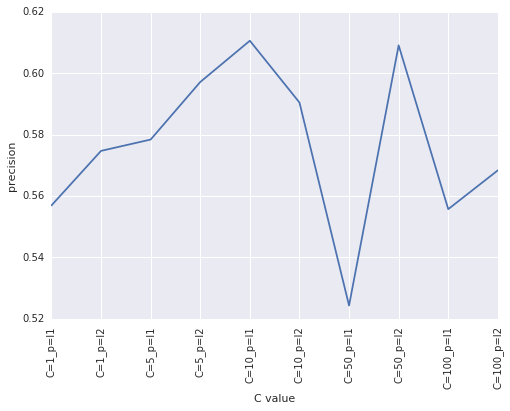

recall
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  5.3min finished


Best parameters set found on development set:
()
{'penalty': 'l1', 'C': 50}
()
Grid scores on development set:
()


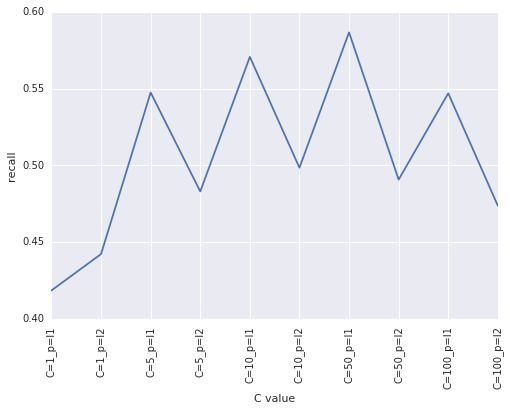

roc_auc
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  5.0min finished


Best parameters set found on development set:
()
{'penalty': 'l1', 'C': 10}
()
Grid scores on development set:
()


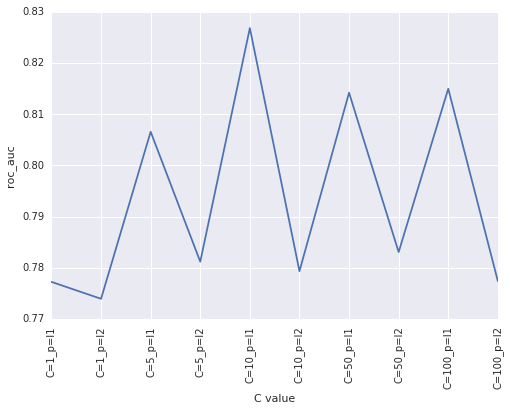

In [5]:






# scores = ['precision', 'recall','roc_auc']
scores = ['roc_auc']
Cs=[1,5,10,50,100]
# Cs=[0.001,0.01,0.1,1,10,100]
# Cs=[0.001,100]
penalties=['l1','l2']
# penalties=['l1']

#generating the cv object:
group_kfold = StratifiedKFold(n_splits=n_splits)
groups = None

# LOOP OVER CV FOLDS:
for train_index, val_index in group_kfold.split(X, Y, groups):
    
    print i
    i += 1
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.loc[X_train.index], Y.loc[X_val.index]


    clf = GridSearchCV(LogisticRegression(), param_grid={'C':Cs,'penalty':penalties}, cv=10,
                       scoring=score,n_jobs=2,verbose=1)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    Xs=[]
    for i in range(len(Cs)):
        for j in range(len(penalties)):
            x='C=%s_p=%s' %(Cs[i],penalties[j])
            Xs.append(x)

    fig,ax=plt.subplots()
    ax.plot(range(len(Xs)),means)
    ax.set_xticks(range(len(Xs)))
    ax.set_xticklabels(Xs,rotation=90)
#     ax.set_xscale('log')
    ax.set_xlabel('C value')
    ax.set_ylabel(score)

    plt.show()
    
    y_pred_proba = m.predict_proba(X_val)
    y_pred_df.loc[y_val.index, :] = np.expand_dims(y_pred_proba[:, 1], 1)



#### FIND THE BEST FEATURES:

0


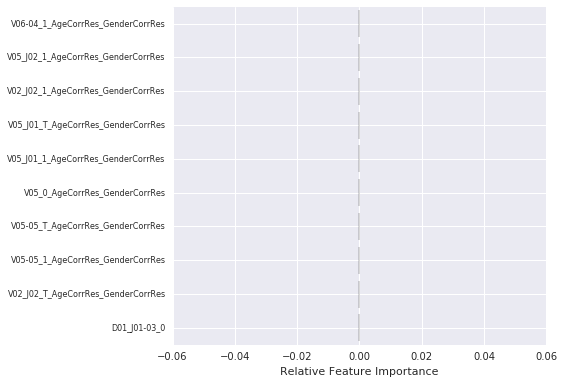

1


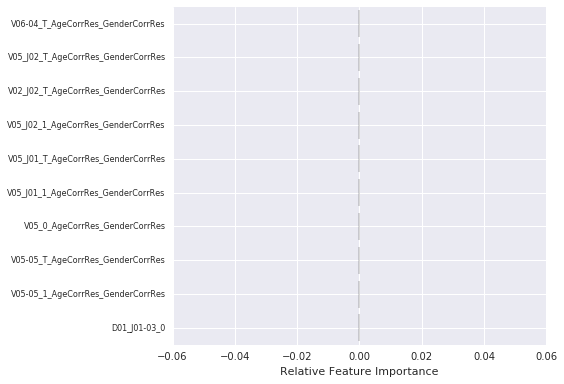

2


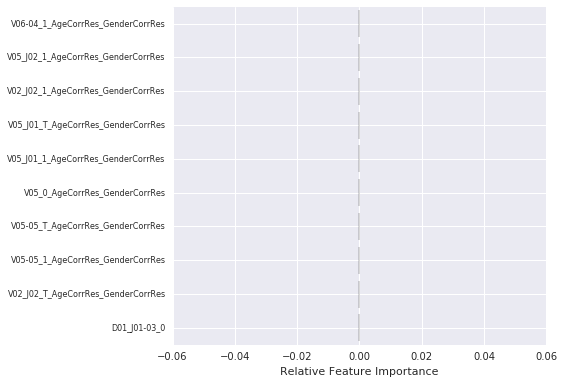

In [15]:
model_params={'C': 10, 'penalty':'l1'}
n_splits=3

#get dfs:
#new X: includes all TCR features, corrected for age and Gender
datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined' %MyPath
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126

f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels_AgeGenderGFRCorr.dat' %MyPath
X_corrected=pd.read_pickle(f1).loc[PNP530Cardio126,:]

targetDF=pd.DataFrame(index=['BD'+str(x) for x in range(1,1100)])
targetDF['isCardio']=np.where(targetDF.index.str.replace('BD','').astype(int)>949,1,0)
targetDF=targetDF.loc[X_corrected.index,:]


X=X_corrected.copy()
Xname='X_AgeGenderGFRCorrected_withRels'
scaler = StandardScaler()
scaler.fit(X) 
X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
Xname=Xname+'_scaled'
Y=targetDF.iloc[:,0]

group_kfold = StratifiedKFold(n_splits=n_splits)
groups = None
y_pred_df = pd.DataFrame(index=Y.index, columns=['pred_proba'])
i = 0

for train_index, val_index in group_kfold.split(X_scaled, Y, groups):
    print i
    i += 1
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.loc[X_train.index], Y.loc[X_val.index]

    clf = LogisticRegression(**model_params)
    clf.fit( X_train,y_train)

    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos[:10], feature_importance[sorted_idx][:10], align='center')
    featax.set_yticks(pos[:10])
    featax.set_yticklabels(np.array(X.columns)[sorted_idx][:10], fontsize=8)
    featax.set_xlabel('Relative Feature Importance')

    plt.tight_layout()   
    plt.show()
    
    y_pred_proba = clf.predict_proba(X_val)
    y_pred_df.loc[y_val.index, :] = np.expand_dims(y_pred_proba[:, 1], 1)

### random search on XGB



In [26]:
from sklearn.model_selection import RandomizedSearchCV

#get dfs:
#new X: includes all TCR features, corrected for age and Gender
datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined' %MyPath
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126

f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels_AgeGenderGFRCorr.dat' %MyPath
X_corrected=pd.read_pickle(f1).loc[PNP530Cardio126,:]

targetDF=pd.DataFrame(index=['BD'+str(x) for x in range(1,1100)])
targetDF['isCardio']=np.where(targetDF.index.str.replace('BD','').astype(int)>949,1,0)
targetDF=targetDF.loc[X_corrected.index,:]


X=X_corrected.copy()
Xname='X_AgeGenderGFRCorrected_withRels'
Y=targetDF.iloc[:,0]

print 'X'
print X.head()

print 'Y'
print Y.head()

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# scores = ['precision', 'recall','roc_auc']
scores = ['roc_auc']
# Cs=[0.01,0.05,0.1,0.5,1,5,10,50,100]
Cs=[0.001,0.01,0.1,1,10,100]
penalties=['l1','l2']

print("# Tuning hyper-parameters for %s" % score)
print()

for score in scores:
    print score
    clf = RandomizedSearchCV(XGBClassifier(), {'learning_rate': [0.001,0.005,0.01,0.05,0.1], 'n_estimators': [50,100,500,1000,5000],'max_depth': [0,1,3,5,10],
                                  'gamma':[0,1,5,10],'reg_alpha':[0,1,5,10],
                                'reg_lambda':[1,5,10]},n_iter=2,scoring=score,n_jobs=2,verbose=1)
    
    clf.fit(X, Y)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     Xs=[]
#     for i in range(len(Cs)):
#         for j in range(len(penalties)):
#             x='C=%s_p=%s' %(Cs[i],penalties[j])
#             Xs.append(x)

#     fig,ax=plt.subplots()
#     ax.plot(range(len(Xs)),means)
#     ax.set_xticks(range(len(Xs)))
#     ax.set_xticklabels(Xs)
# #     ax.set_xscale('log')
#     ax.set_xlabel('C value')
#     ax.set_ylabel(score)

#     plt.show()


X
       D01_J01-03_0  D01_J01-03_1  D01_J01-03_T  D01_J02-06_0  D02_J01-03_0  \
BD406           0.0      0.000000      0.000000      0.010760           0.0   
BD228           0.0      0.000122      0.000094      0.015108           0.0   
BD714           0.0      0.000000      0.000000      0.008874           0.0   
BD808           0.0      0.000000      0.000000      0.010067           0.0   
BD144           0.0      0.000094      0.000074      0.009427           0.0   

       D02_J01-03_1  D02_J01-03_T  D02_J01-05_0  D02_J01-05_T  D02_J02-04_1  \
BD406      0.000000      0.000000      0.000672      0.000153      0.010322   
BD228      0.000000      0.000000      0.000000      0.000188      0.007829   
BD714      0.000000      0.000000      0.000000      0.000124      0.006996   
BD808      0.000000      0.000000      0.000000      0.000068      0.005911   
BD144      0.000094      0.000074      0.000000      0.000592      0.007417   

                        ...                     

[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   10.6s finished


Best parameters set found on development set:
()
{'reg_alpha': 10, 'learning_rate': 0.1, 'n_estimators': 100, 'reg_lambda': 10, 'max_depth': 10, 'gamma': 5}
()


In [29]:
df=pd.DataFrame(index=[0], data=clf.best_params_)
df

,gamma,learning_rate,max_depth,n_estimators,reg_alpha,reg_lambda
0,5,0.1,10,100,10,10


# old stuff:

## plot the association of best ROC-AUC features with isCardio:

In [5]:
bestROCfeats=['HSV_seq_count_AgeCorrRes','Plasmodiumberghei_seq_count_AgeCorrRes_GenderCorrRes','Lungcancer_seq_count_AgeCorrRes_GenderCorrRes','CMV_cum_freq(perc)_GenderCorrRes',
              'HCV_cum_freq(perc)_GenderCorrRes','HTLV_cum_freq(perc)_GenderCorrRes','HIV_cum_freq(perc)','V05-02_1_GenderCorrRes','WestNilevirus_seq_count_AgeCorrRes_GenderCorrRes',
              'EBV_cum_freq(perc)','V05-02_T_GenderCorrRes','frequencyCount (%)_max_0_AgeCorrRes_GenderCorrRes','Influenza_cum_freq(perc)','n2Insertion_mean_1']


# Lupus_seq_count_GenderCorrRes
# Lupus_cum_freq(perc)_GenderCorrRes
# Lungcancer_cum_freq(perc)_GenderCorrRes
# count (templates)_std_0_AgeCorrRes_GenderCorrRes
# n2Insertion_mean_T
# frequencyCount (%)_std_0_AgeCorrRes_GenderCorrRes



In [6]:
#new X: includes all TCR features, corrected for age and Gender
datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined' %MyPath
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126

f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__AgeGenderCorr.dat' %MyPath
X_corrected=pd.read_pickle(f1).loc[PNP530Cardio126,:]
print ('X_corrected shape is:', X_corrected.shape)

targetDF=pd.DataFrame(index=['BD'+str(x) for x in range(1,1100)])
targetDF['isCardio']=np.where(targetDF.index.str.replace('BD','').astype(int)>949,1,0)
targetDF=targetDF.loc[X_corrected.index,:]
print ('targetDF shape is:', targetDF.shape)

IOError: [Errno 2] No such file or directory: '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__AgeGenderCorr.dat'

In [ ]:
for feature in bestROCfeats:
    print feature
    feat_data=pd.DataFrame(X_corrected[feature])
    target_Data=pd.DataFrame(targetDF)
    
    merged=pd.merge(feat_data,target_Data,how='inner',left_index=True,right_index=True)
    print ('merged shape:',merged.shape)
    
    data={}
    for name,groups in merged.groupby('isCardio'):
        data[name]=groups[feature].tolist()
    
    dataList=[('healthy',data[0]),('patients',data[1])]
    fig,ax=plt.subplots(figsize=(4,3))
    title=feature
    plotHistComprison(dataList,ax,title)
#     ,showLegend=True,nBins=20,toAnnotate=True,alpha=None,plotType='hist')
    plt.show()

ROC doesn't seem to reflect true relationships between features and class!

## calculate associations between all corrected features and isCardio:

In [ ]:
featureDF=X_corrected
featureDFname='X_AgeGenderCorr'
phenDF=targetDF
phenDFname='isCardio'
FDR=0.1



feature_phen_ttest=calc_catPhens_TCRfeatures_associations_ttest(featureDF,featureDFname,phenDF,phenDFname,FDR)

In [ ]:
feature_phen_ttest[feature_phen_ttest['sig. by FDR=0.1']==1]

## calculate association between all corrected features and nTemplates:

# plot important feature distributions:
important are the one that distinguised patients and controls the most. plotting shoes this features before correction to age, gender and eGFR to enable understaning

In [ ]:
# featurelist=['Plasmodiumberghei_seq_count','HSV_seq_count','Lungcancer_seq_count','HIV_cum_freq(perc)']

featurelist=['d3Deletion_std_0','V05-06_1','vDeletion_max_T']
#get data:
datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined' %MyPath
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126

f1='%s/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10_.dat' %MyPath
X=pd.read_pickle(f1).loc[PNP530Cardio126,:]

targetDF=pd.DataFrame(index=['BD'+str(x) for x in range(1,1100)])
targetDF['isCardio']=np.where(targetDF.index.str.replace('BD','').astype(int)>949,1,0)
targetDF=targetDF.loc[X.index,:]

#generate comparisons:

fig3,axes3=plt.subplots(nrows=1,ncols=4,figsize=(20,4))

for n,feature in enumerate(featurelist):
    print n,feature
    ax=axes3.flatten()[n]
    try:
        featureData=pd.DataFrame(X[feature])
    except:
        try:
            featureData=pd.DataFrame(X[feature+'_AgeCorrRes']) 
        except:
            print 'couldnt find feature data'
    featureName=featureData.columns[0]
                
    data=pd.merge(featureData,targetDF,how='inner',
                  left_index=True,right_index=True)
    groups=data.groupby('isCardio') #group the df by the phenotype cateogries
    dataList=[] #generate datalist constitutes of tuples, each tuple contain a category name and its relevent feature data
    print '-groups- length is %s' %len(groups)
    for name,group in groups:
        tupList=[]
        tupList.append(name)
        groupData=[x for x in group[featureName].tolist() if not np.isnan(x)]
        tupList.append(groupData)
        tup=tuple(tupList)
        dataList.append(tup)

    title=None
    ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,
                                                showLegend=True,nBins=20,toAnnotate=False,alpha=0.5,
                                                    plotType='hist')
     
    ax.locator_params(axis='x', nbins=4,fontsize='xx-large')
    ax.set_title(feature,fontsize='xx-large',y=1.04)
    
    if n==0:
        ax.set_ylabel('Density',fontsize='x-large')
        L=ax.legend()
        L.get_texts()[0].set_text('Controls')
        L.get_texts()[1].set_text('Patients')
       
    else:
        ax.legend('')
#                  ,fontsize='large')
#     if not np.isnan(p_Anov):
#                 ax.annotate('p_Anov=%s' %round(p_Anov,4),xy=(0.02, 0.96), xycoords='axes fraction', 
#                 fontsize='x-large', horizontalalignment='left', verticalalignment='top', fontweight='bold',color='red')
#     else:
#         ax.annotate('ttest_p=%s' %round(t_p_cohort1_cohort2,4),xy=(0.02, 0.96), xycoords='axes fraction', 
#     fontsize='x-large', horizontalalignment='left', verticalalignment='top', fontweight='bold',color='red')
plt.rcParams.update({'legend.fontsize': 20})
fig3.subplots_adjust(wspace=0.3,top=0.95)       

# figName='3-PNP-Cardio feature comparison'
# figFile='%s/%s' %(posterFolder,figName)
# fig3.savefig(figFile,dpi=300,bbox_inches='tight')
plt.show()
    